In [8]:
import os
import re
import sys
import torch
import scipy.io
import scipy.signal
import mat73
import imageio
import lpips
import random
import torchvision
import random
import time
import skimage._shared.utils
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn as nn
import torch.fft as fft
import torch.nn.functional as F
import cv2 as cv
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.utils import save_image
from PIL import Image
from skimage import color, data, restoration, img_as_float
from tqdm import tqdm
from unet import UNet # httaps://github.com/ELEKTRONN/elektronn3
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import uft
from pypfm import PFMLoader
loader = PFMLoader(color=False, compress=False)
import matplotlib as mpl
%matplotlib inline

### helper functions

In [9]:
data_dir = '/media/data/salman/Lensless3D/'
dataset_dir = data_dir + 'data/FlyingThings3D_subset/'
data_dict_psf = mat73.loadmat(data_dir+'data/psfs_save_magfs.mat')
psfs = data_dict_psf['psfs'][:,:,:,-25:][::2,::2]

def show_figure(image1, title1, mode="single", image2=None, title2=None, colorbar=False, depth_mod=False, save=False, img_name=None, cmap='gray'):
    
    if mode=='single':
        fig = plt.figure()
        plt.axis('off')
        plt.imshow(image1, cmap=cmap)
        
    if mode=='single-colorbar':
        fig, ax = plt.subplots()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.2)

        im1 = ax.imshow(image1, cmap=cmap)
        ax.set_title(title1)

        fig.colorbar(im1, cax=cax, orientation='vertical')
        
    elif mode=='comparison':
        if depth_mod:
            max1 = np.max(image1)
            max2 = np.max(image2)
            if max2>max1:
                max_ = max2
            else:
                max_ = max1
            image1[0, 0] = max_
            image2[0, 0] = max_
        fig, (ax1, ax2) = plt.subplots(1, 2)
        im1 = ax1.imshow(image1, cmap=cmap)
        ax1.set_title(title1)
        im2 = ax2.imshow(image2, cmap=cmap)
        ax2.set_title(title2)
        
        if colorbar:
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes('right', size='5%', pad=0.2)
            fig.colorbar(im1, cax=cax, orientation='vertical')
            divider = make_axes_locatable(ax2)
            cax = divider.append_axes('right', size='5%', pad=0.2)
            fig.colorbar(im2, cax=cax, orientation='vertical')
            fig.tight_layout(pad=1.0)
        
        fig.show()
        
    if save:
        fig.savefig(img_name)

    
from struct import *
def load_pfm(file_path):
    """
    load image in PFM type.
    Args:
        file_path string: file path(absolute)
    Returns:
        data (numpy.array): data of image in (Height, Width[, 3]) layout
        scale (float): scale of image
    """
    with open(file_path, encoding="ISO-8859-1") as fp:
        color = None
        width = None
        height = None
        scale = None
        endian = None

        # load file header and grab channels, if is 'PF' 3 channels else 1 channel(gray scale)
        header = fp.readline().rstrip()
        if header == 'PF':
            color = True
        elif header == 'Pf':
            color = False
        else:
            raise Exception('Not a PFM file.')

        # grab image dimensions
        dim_match = re.match(r'^(\d+)\s(\d+)\s$', fp.readline())
        if dim_match:
            width, height = map(int, dim_match.groups())
        else:
            raise Exception('Malformed PFM header.')

        # grab image scale
        scale = float(fp.readline().rstrip())
        if scale < 0:  # little-endian
            endian = '<'
            scale = -scale
        else:
            endian = '>'  # big-endian

        # grab image data
        data = np.fromfile(fp, endian + 'f')
        shape = (height, width, 3) if color else (height, width)

        # reshape data to [Height, Width, Channels]
        data = np.reshape(data, shape)
        data = np.flipud(data)

        return data

class VGG(nn.Module):
    """VGG/Perceptual Loss
    
    Parameters
    ----------
    conv_index : str
        Convolutional layer in VGG model to use as perceptual output

    """
    def __init__(self, conv_index: str = '22'):

        super(VGG, self).__init__()
        vgg_features = torchvision.models.vgg19(pretrained=False).features
        modules = [m for m in vgg_features]
        
        if conv_index == '22':
            self.vgg = nn.Sequential(*modules[:8])
        elif conv_index == '54':
            self.vgg = nn.Sequential(*modules[:35])

        vgg_mean = (0.485, 0.456, 0.406)
        vgg_std = (0.229, 0.224, 0.225)
        #self.sub_mean = common.MeanShift(rgb_range, vgg_mean, vgg_std)
        self.vgg.requires_grad = False

    def forward(self, sr: torch.Tensor, hr: torch.Tensor) -> torch.Tensor:
        """Compute VGG/Perceptual loss between Super-Resolved and High-Resolution

        Parameters
        ----------
        sr : torch.Tensor
            Super-Resolved model output tensor
        hr : torch.Tensor
            High-Resolution image tensor

        Returns
        -------
        loss : torch.Tensor
            Perceptual VGG loss between sr and hr

        """

        def _forward(x):
            #x = self.sub_mean(x)
            x = x.cpu()
            x = self.vgg(x)
            return x
            
        vgg_sr = _forward(sr)

        with torch.no_grad():
            vgg_hr = _forward(hr.detach())

        loss = F.mse_loss(vgg_sr, vgg_hr)

        return loss
    
## AIF metrics; gt, recon must be scaled from 0-1, dim:(128, 128, 3)

loss_fn_alex = lpips.LPIPS(net='alex')

def PSNR(gt, recon):
    mse = np.mean((gt - recon) ** 2)
    if(mse == 0): 
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def SSIM(gt, recon):
    return ssim(gt, recon, multichannel=True)

def LPIPSval(gt, recon):
    gt = torch.from_numpy(gt.transpose(2, 0, 1).reshape(1, 3, 128, 128)).type(torch.float32)
    recon = torch.from_numpy(recon.transpose(2, 0, 1).reshape(1, 3, 128, 128)).type(torch.float32)
    return loss_fn_alex(gt, recon).item()
    
## Depth metrics

def RMSE(gt, recon):
    mse = np.mean((gt - recon) ** 2)
    return np.sqrt(mse)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/lensless/.conda/envs/myenv/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth


### dataloader

In [10]:
class TestDataset(Dataset):
    def __init__(self, meas_folder, x1, x2, noise):
        self.meas_folder = meas_folder
        self.x1 = x1
        self.x2 = x2
        self.noise = noise
    
    def __len__(self):
        return 1248

    def __getitem__(self, index):

        x1 = self.x1
        x2 = self.x2
        allfocus = np.zeros([1, 3, 128, 128])
        img_no = '0'*(7-len(str(index+3000))) + str(index+3000)
        allfocus[0,...] = np.array(Image.open(dataset_dir+'val/left/'+str(img_no)+'.png'))[::2, ::2, :][:256, 100:356, :][::2,::2,:].transpose(2, 0, 1)/255
        img = allfocus[0,...]
        depth = np.zeros([1, 256, 256])
        disp = load_pfm(dataset_dir+'val/disparity/left/'+str(img_no)+'.pfm')[::2, ::2][:256, 100:356]
        depth = 1/np.abs(disp)        
        dx1 = data_dict_psf['drng'][-25+x1]
        dx2 = data_dict_psf['drng'][-25+x2-1]
        
        depth_1 = dx1+(dx2-dx1)*(depth - depth.min())/(depth.max()-depth.min())
#         bin_ = depth.min() + (depth.max() - depth.min())*(data_dict_psf['drng'][-25:]-3.6)/(20-3.6)
#         new_depth = np.clip(np.digitize(depth,bin_,right=True)[::2,::2],0,24)
        if x2==25:
            x2 = 24
        bin_ = depth.min() + (depth.max() - depth.min())*(data_dict_psf['drng'][-25+x1:-25+x2]-dx1)/(dx2-dx1)
        if x2==24:
            x2 = 25
        new_depth = np.clip(np.digitize(depth,bin_,right=True)[::2,::2],0,x2-x1) + x1
        measurement = np.zeros([456, 684, 3])
        left = (data_dict_psf['psfs'].shape[0]//2-128)//2
        top = (data_dict_psf['psfs'].shape[1]//2-128)//2
        
        for c in range(3):
            img_scale = 1
            j = 0
            ch = c
            if c==2:
                ch = -1
            for i in np.unique(new_depth):
                img1 = img[c,:,:].copy()
                j+=1
                img1[np.where(new_depth != i)] = 0
                img1 = np.pad(img1,((left,left),(top,top)))/255
                measurement[:, :, c] += np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.fft2(data_dict_psf['psfs'][:,:,ch,24+i][::2,::2])*np.fft.fft2(img1))))
            measurement[:, :, c] = measurement[:, :, c]/j
        
        max_m = np.max(measurement)
        mse = 10**(np.log10(max_m**2)-self.noise/10)
        noise = np.random.normal(0, np.sqrt(mse), np.shape(measurement))
        noisy_measurement = measurement + noise
        measurement = noisy_measurement
        measurement -= np.min(measurement)
        measurement /= np.max(measurement)
        measurement = (255*measurement).astype(np.uint8)
        
        return measurement, depth_1[::2, ::2], allfocus

  0%|          | 0/1 [00:00<?, ?it/s]

0.1630731225013733 1.267797916465615 22.51764505944907


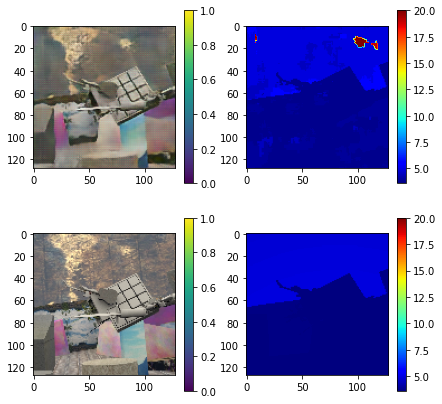

  0%|          | 0/1 [00:00<?, ?it/s]

0.23470519483089447 4.630306720516947 19.8670203706048


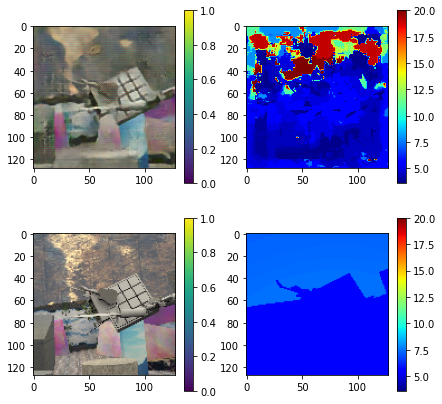

  0%|          | 0/1 [00:00<?, ?it/s]

0.26631268858909607 4.3950104228360045 20.29621258575351


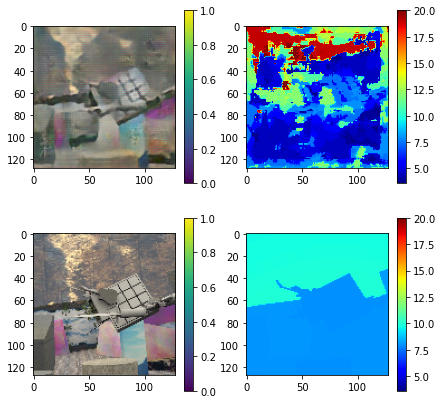

  0%|          | 0/1 [00:00<?, ?it/s]

0.2905806005001068 5.4937272255843626 19.98674020469602


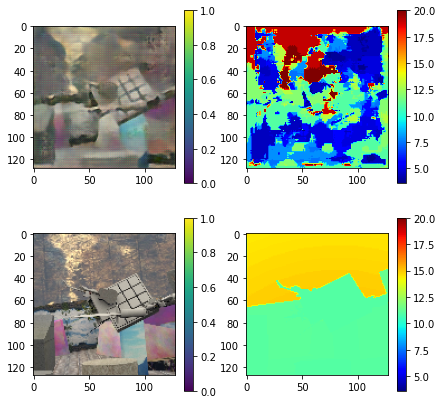

  0%|          | 0/1 [00:00<?, ?it/s]

0.3083657920360565 9.216487550356554 19.7526390177209


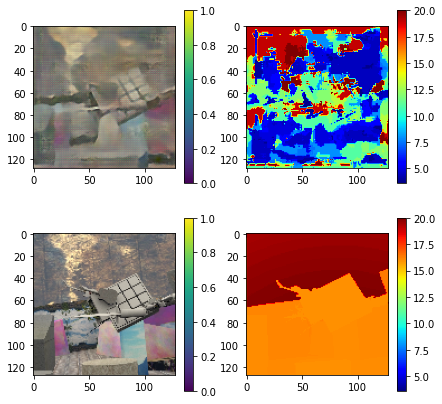

100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


In [33]:
# PATH = data_dir+"models/model_rgbdnet_2_94.pt"
# device = 'cuda:0'
# model = UNet(in_channels=25,
#              out_channels=26,
#              in_layer='filter',
#              device = device,
#              batch_size = 7,
#              n_blocks=2,
#              start_filts = 64,
#              attention = True,
#              activation=nn.ELU(),
#              normalization='batch',
#              conv_mode='same',
#              out_layer='3Dvol',
#              dim=3).to(device)
# state_dict = torch.load(PATH,map_location='cpu')
# model.load_state_dict(state_dict)
# model.to(device)
# model.eval()
# uncomment above part for lw model

device = 'cuda:3'
model = UNet(in_channels=25,
             out_channels=26,
             in_layer='filter',
             device = device,
             batch_size = 9,
             n_blocks=2,
             start_filts = 64,
             attention = True,
             activation=nn.ELU(),
             normalization='batch',
             conv_mode='same',
             out_layer='3Dvol',
             fixed=True,
             dim=3).to(device)

PATH = data_dir+"models/model_rgbdnet_fw_42.pt"
state_dict = torch.load(PATH,map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

lower_limit = [0, 5, 10, 15, 20]
rmse_array = np.zeros(len(lower_limit))

arr = np.load('test_indices.npy')

for i in range(len(lower_limit)):
    rmse_sum = 0
    psnr_sum = 0
    low = lower_limit[i]
    high = low+5
    test_dataset = TestDataset(meas_folder='meas_50', x1=low, x2=high, noise=60)
    #arr = [500, 370, 201, 204, 816, 735, 239, 201]
    for t in tqdm(range(1)):
        k = arr[11]
        x = torch.from_numpy(test_dataset[k][0]).unsqueeze(0).permute(0, 3, 1, 2).to(device).type(torch.float32)
        with torch.no_grad():
            out_d = data_dict_psf['drng'][-25:][torch.argmax(model(x)[0, 1:26,0,...], dim=0).cpu()]
            out_aif = model(x)[0, 0,...].cpu().numpy()
            out_aif -= np.min(out_aif)
            out_aif /= np.max(out_aif)
        print(LPIPSval(test_dataset[k][2][0].transpose(1, 2, 0), out_aif.transpose(1, 2, 0)), RMSE(test_dataset[k][1], out_d), PSNR(test_dataset[k][2][0], out_aif))
        
        depth_gt = test_dataset[k][1].copy()
        depth_gt[0,0] = 3.6
        depth_gt[0,1] = 20.0
        out_d[0,0]=3.6
        out_d[0,1]=20
        
        #show_figure(out_aif.transpose(1, 2, 0), 'recon aif', 'comparison', test_dataset[k][2][0].transpose(1, 2, 0), 'gt aif')
#         cv.imwrite('expt3/aif_recon'+str(i)+str(t)+'.png', cv.cvtColor((255*out_aif.transpose(1, 2, 0)).astype(np.uint8), cv.COLOR_RGB2BGR))    
#         cv.imwrite('expt3/aif_gt'+str(t)+'.png', cv.cvtColor((255*test_dataset[k][2][0].transpose(1, 2, 0)).astype(np.uint8), cv.COLOR_RGB2BGR))    
        #show_figure(out_d, 'recon depth', 'comparison', test_dataset[k][1], 'gt depth', cmap='jet', colorbar=True, depth_mod=True, save=True, img_name='expt3/depth_comp.png'+str(i)+str(t)+'.png')
        plt.figure(figsize=(7,7))
        plt.subplot(2,2,1)
        plt.imshow(out_aif.transpose(1, 2, 0))
        plt.colorbar()
        plt.subplot(2,2,2)
        plt.imshow(out_d,cmap='jet')
        plt.colorbar()
        plt.subplot(2,2,3)
        plt.imshow(test_dataset[k][2][0].transpose(1, 2, 0))
        plt.colorbar()
        plt.subplot(2,2,4)
        plt.imshow(depth_gt,cmap='jet')
        plt.colorbar()
        plt.show()
    
    

0
33
0.08159853518009186 0.22051769459033238 21.864710678001128
0.08159853518009186 0.22051769459033238 21.864710678001128
5
33
0.1678110957145691 1.2075577105451096 19.873665743065366
0.1678110957145691 1.2075577105451096 19.873665743065366
10
33
0.1629061996936798 1.5154424560313657 20.369149513620926
0.1629061996936798 1.5154424560313657 20.369149513620926
15
33
0.15814951062202454 2.7038427722449123 21.779611071238108
0.15814951062202454 2.7038427722449123 21.779611071238108
20
33
0.17253422737121582 4.1516266837785665 21.028527413432293
0.17253422737121582 4.1516266837785665 21.028527413432293


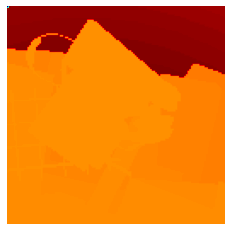

In [77]:
PATH = data_dir+"models/model_rgbdnet_2_94.pt"
device = 'cuda:3'
model = UNet(in_channels=25,
          out_channels=26,
          in_layer='filter',
          device = device,
          batch_size = 7,
          n_blocks=2,
          start_filts = 64,
          attention = True,
          activation=nn.ELU(),
          normalization='batch',
          conv_mode='same',
          out_layer='3Dvol',
          dim=3).to(device)
state_dict = torch.load(PATH,map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)
model.eval()

lower_limit = [0, 5, 10, 15, 20]
rmse_array = np.zeros(len(lower_limit))
arr = np.load('test_indices.npy')

metrics = np.zeros((5,3))

for i in range(len(lower_limit)):
    rmse_sum = 0
    psnr_sum = 0
    low = lower_limit[i]
    high = low+5
    test_dataset = TestDataset(meas_folder='meas_50', x1=low, x2=high, noise=60)
    print(low)
    #arr = [500, 370, 201, 204, 816, 735, 239, 201]
    #for t in tqdm(range(1)):
    for t in range(1):
        k = 33
        print(k)
        x = torch.from_numpy(test_dataset[k][0]).unsqueeze(0).permute(0, 3, 1, 2).to(device).type(torch.float32)
        with torch.no_grad():
            out_d = data_dict_psf['drng'][-25:][torch.argmax(model(x)[0, 1:26,0,...], dim=0).cpu()]
            out_aif = model(x)[0, 0,...].cpu().numpy()
            out_aif -= np.min(out_aif)
            out_aif /= np.max(out_aif)
            
            
#        show_figure(out_aif.transpose(1, 2, 0), 'recon aif', 'comparison', test_dataset[k][2][0].transpose(1, 2, 0), 'gt aif')
#         cv.imwrite('expt3/aif_recon'+str(i)+str(t)+'.png', cv.cvtColor((255*out_aif.transpose(1, 2, 0)).astype(np.uint8), cv.COLOR_RGB2BGR))    
#         cv.imwrite('expt3/aif_gt'+str(t)+'.png', cv.cvtColor((255*test_dataset[k][2][0].transpose(1, 2, 0)).astype(np.uint8), cv.COLOR_RGB2BGR))    
#        show_figure(out_d, 'recon depth', 'comparison', test_dataset[k][1], 'gt depth', cmap='jet', colorbar=True, depth_mod=True, save=True, img_name='expt3/depth_comp.png'+str(i)+str(t)+'.png')
        print(LPIPSval(test_dataset[k][2][0].transpose(1, 2, 0), out_aif.transpose(1, 2, 0)), RMSE(test_dataset[k][1], out_d), PSNR(test_dataset[k][2][0], out_aif))
        
        metrics[i,0] = PSNR(test_dataset[k][2][0], out_aif)
        metrics[i,1] = LPIPSval(test_dataset[k][2][0].transpose(1, 2, 0), out_aif.transpose(1, 2, 0))
        metrics[i,2] = RMSE(test_dataset[k][1], out_d)
        
        img_no = '0'*(7-len(str(k+3000))) + str(k+3000)
        disp = load_pfm('data/FlyingThings3D_subset/val/disparity/left/'+str(img_no)+'.pfm')[::2, ::2][:256, 100:356]
        depth_ = 1/(np.abs(disp))
        depth_ = data_dict_psf['drng'][-25:][low] + (data_dict_psf['drng'][-25:][high-1]-data_dict_psf['drng'][-25:][low])*(depth_-depth_.min())/(depth_.max()-depth_.min())
        depth_ = depth_[::2,::2]
        
        print(LPIPSval(test_dataset[k][2][0].transpose(1, 2, 0), out_aif.transpose(1, 2, 0)), RMSE(depth_, out_d), PSNR(test_dataset[k][2][0], out_aif))
        
        #depth_gt = test_dataset[k][1].copy()
        #depth_gt[0,0] = 3.6
        #depth_gt[0,1] = 20.0
        depth_[0,0] = 3.6
        depth_[0,1] = 20.0
        
        out_d[0,0]=3.6
        out_d[0,1]=20
        
        plt.imshow(out_aif.transpose(1, 2, 0))
        plt.axis('off')
        plt.savefig("depth_ablation/img1/aif/"+str(k)+"-"+str(data_dict_psf['drng'][-25:][low])+'-'+str(data_dict_psf['drng'][-25:][high-1])+".png",bbox_inches='tight',pad_inches=0,dpi=42.5)
        plt.imshow(out_d,cmap='jet')
        plt.axis('off')
        plt.savefig("depth_ablation/img1/depth/"+str(k)+"-"+str(data_dict_psf['drng'][-25:][low])+'-'+str(data_dict_psf['drng'][-25:][high-1])+".png",bbox_inches='tight',pad_inches=0,dpi=42.5)
        plt.imshow(test_dataset[k][2][0].transpose(1, 2, 0))
        plt.axis('off')
        plt.savefig("depth_ablation/img1/aif_gt/"+str(k)+"-"+str(data_dict_psf['drng'][-25:][low])+'-'+str(data_dict_psf['drng'][-25:][high-1])+".png",bbox_inches='tight',pad_inches=0,dpi=42.5)
        plt.imshow(depth_,cmap='jet')
        plt.axis('off')
        plt.savefig("depth_ablation/img1/depth_gt/"+str(k)+"-"+str(data_dict_psf['drng'][-25:][low])+'-'+str(data_dict_psf['drng'][-25:][high-1])+".png",bbox_inches='tight',pad_inches=0,dpi=42.5)
        #plt.figure(figsize=(7,7))
        #plt.subplot(2,2,1)
        #plt.imshow(out_aif.transpose(1, 2, 0))
        #plt.colorbar()
        #plt.subplot(2,2,2)
        #plt.imshow(out_d,cmap='jet')
        #plt.colorbar()
        #plt.subplot(2,2,3)
        #plt.imshow(test_dataset[k][2][0].transpose(1, 2, 0))
        #plt.colorbar()
        #plt.subplot(2,2,4)
        #plt.imshow(depth_gt,cmap='jet')
        #plt.colorbar()
        #plt.show()
np.save('depth_ablation/img1/metrics',metrics)

In [70]:
np.load('depth_ablation/img3/metrics.npy')

array([[21.16937788,  0.06164466,  0.29507838],
       [21.01287729,  0.11912441,  1.2747617 ],
       [21.31506444,  0.14999685,  1.13192025],
       [22.02634273,  0.15498111,  2.98770731],
       [21.83630855,  0.15052514,  5.39730733]])

In [58]:
data_dict_psf['drng'][-25:][high-1]

20.0

In [12]:
!nvidia-smi

Mon Sep  6 11:36:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 48%   81C    P2    98W / 250W |  11171MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 35%   53C    P8    13W / 250W |   4972MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [63]:
!rm -r depth_ablation/img1/aif/*

In [71]:
!zip -r depth_ablation.zip depth_ablation/

  adding: depth_ablation/ (stored 0%)
  adding: depth_ablation/img2/ (stored 0%)
  adding: depth_ablation/img2/aif/ (stored 0%)
  adding: depth_ablation/img2/aif/29-8.0-10.0.png (deflated 0%)
  adding: depth_ablation/img2/aif/29-11.0-15.0.png (deflated 0%)
  adding: depth_ablation/img2/aif/29-5.5-7.5.png (deflated 0%)
  adding: depth_ablation/img2/aif/29-3.6-5.0.png (deflated 0%)
  adding: depth_ablation/img2/aif/29-16.0-20.0.png (deflated 0%)
  adding: depth_ablation/img2/metrics.npy (deflated 26%)
  adding: depth_ablation/img2/depth/ (stored 0%)
  adding: depth_ablation/img2/depth/29-8.0-10.0.png (stored 0%)
  adding: depth_ablation/img2/depth/29-11.0-15.0.png (stored 0%)
  adding: depth_ablation/img2/depth/29-5.5-7.5.png (stored 0%)
  adding: depth_ablation/img2/depth/29-3.6-5.0.png (stored 0%)
  adding: depth_ablation/img2/depth/29-16.0-20.0.png (stored 0%)
  adding: depth_ablation/img2/aif_gt/ (stored 0%)
  adding: depth_ablation/img2/aif_gt/29-8.0-10.0.png (deflated 0%)
  adding: